In [7]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

# Writing Random Forest Regresssor from Scrach

In [2]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class MyRandomForestRegressor:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            bootstrap_indices = np.random.choice(len(X), len(X), replace=True)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]
            
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf
            )
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros(len(X))
        for tree in self.trees:
            tree_predictions = tree.predict(X)
            predictions += tree_predictions
        return predictions / len(self.trees)




# Training Random Forest Regressor on daily data

>expected=10379305.0, predicted=9927398.3
>expected=9680446.0, predicted=9984611.6
>expected=10124238.0, predicted=9813159.7
>expected=9464659.0, predicted=10047189.8
>expected=9703857.0, predicted=9949166.1
>expected=10045897.0, predicted=9917352.0
>expected=10738865.0, predicted=9901399.2
>expected=10350408.0, predicted=10009306.4
>expected=10219445.0, predicted=10017037.1
>expected=10313337.0, predicted=9787405.8
>expected=10310644.0, predicted=10009619.1
>expected=10211187.0, predicted=10040550.3
MAE: 366841.964


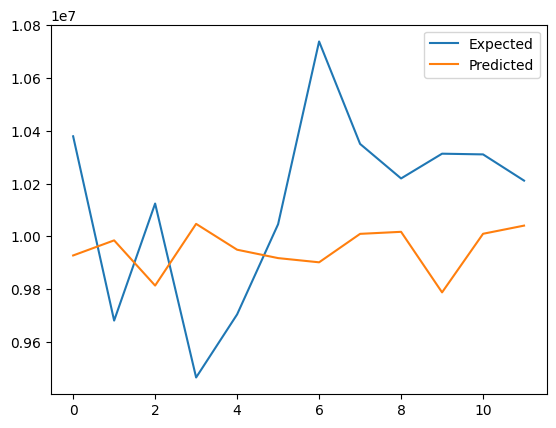

In [3]:
# forecast monthly births with random forest
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = MyRandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
series = read_csv('data_daily.csv', header=0, index_col=0)
values = series.values
n_in=17
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

## Fitting the model and saving it

In [4]:
import numpy as np
import pickle
from pandas import read_csv
n_in=17
series = read_csv('data_daily.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = MyRandomForestRegressor(n_estimators=1000)
model.fit(trainX, trainy)
pickle.dump(model, open('rfmodel.pkl','wb'))



## Predicting the future 366 days for 2022

In [5]:
# construct an input for a new prediction
for i in range(366):
    row = values[-n_in:].flatten()
    # make a one-step prediction
    yhat = model.predict(asarray([row]))
    print('Input: %s, Predicted: %.3f' % (row[-1], yhat[0]))
    values=np.append(values,[yhat[0]]).reshape(-1,1)

Input: 10211187, Predicted: 10008527.129
Input: 10008527.129, Predicted: 9938914.129
Input: 9938914.129, Predicted: 9978103.149
Input: 9978103.149, Predicted: 10043696.998
Input: 10043696.998, Predicted: 9920407.054
Input: 9920407.054, Predicted: 9801102.799
Input: 9801102.799, Predicted: 9920694.917
Input: 9920694.917, Predicted: 10097805.382
Input: 10097805.382, Predicted: 10089441.689
Input: 10089441.689, Predicted: 10164714.140
Input: 10164714.14, Predicted: 10179831.636
Input: 10179831.636, Predicted: 10156084.330
Input: 10156084.33, Predicted: 10170968.114
Input: 10170968.114, Predicted: 10065823.994
Input: 10065823.994, Predicted: 9977764.739
Input: 9977764.739, Predicted: 9945975.081
Input: 9945975.081, Predicted: 9962221.347
Input: 9962221.347, Predicted: 9931944.548
Input: 9931944.548, Predicted: 9937675.011
Input: 9937675.011, Predicted: 9944386.902
Input: 9944386.902, Predicted: 10042133.479
Input: 10042133.479, Predicted: 10053552.341
Input: 10053552.341, Predicted: 101225

## Plot and observation
Here we can observe that Random Forest regressor has captured the volatility of the data but the data does not seem to be capturing the exponential/linear increase

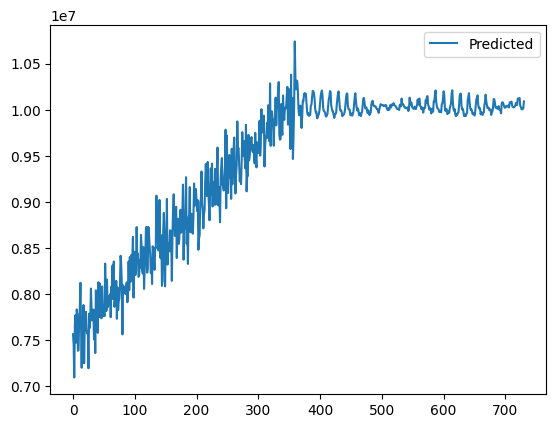

In [6]:

pyplot.plot(values, label='Predicted')
pyplot.legend()
pyplot.show()


# GARCH
Here I decided to use GARCH to find the volatility forecast and attempt to predict volatility and upper lower bound.
For this first I needed a residual array of the prediction and the real values. So I used the RFR model to predict 40 values.

In [9]:
series = read_csv('data_daily.csv', header=0, index_col=0)
truevalues = series.values
n_in=17
data = series_to_supervised(truevalues, n_in)
# evaluate
mae, y, yhat = walk_forward_validation(data, 40)
residuals=y-yhat
import pandas as pd
from arch import arch_model

# Assuming 'residuals' is a pandas Series containing the residuals
# Specify the GARCH model order (p and q) and other parameters
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)

# Fit the GARCH model
garch_model_fit = garch_model.fit()

# Display model summary
print(garch_model_fit.summary())

# Get volatility forecasts for future periods
forecast_horizon = 5  # Adjust as needed
forecast = garch_model_fit.forecast(horizon=forecast_horizon)

import numpy as np

# Assuming you have the GARCH model and Random Forest predictions
# garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
# rf_predictions = ...  # Replace with your Random Forest predictions

# Set the desired confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate the z-score for the desired confidence level
from scipy.stats import norm
z_score = norm.ppf(1 - (1 - confidence_level) / 2)

# Get the last forecasted volatility value from the GARCH model
last_forecasted_volatility = garch_model_fit.forecast(horizon=1).variance.iloc[-1, :].values[0]

# Calculate the margin of error
margin_of_error = z_score * np.sqrt(last_forecasted_volatility)

# Calculate the lower and upper bounds of the prediction interval
lower_bound = values - margin_of_error
upper_bound = values + margin_of_error

print("Prediction Interval for {}% Confidence:".format(int(confidence_level * 100)))
for i in range(365,len(values)):
    print('>Lower=%.1f,Prediction=%.1f, Upper=%.1f' % (lower_bound[i],values[i],upper_bound[i]))



>expected=9608834.0, predicted=9781514.4
>expected=9893666.0, predicted=9841472.5
>expected=9897017.0, predicted=9728055.5
>expected=10129048.0, predicted=9911306.1
>expected=9828852.0, predicted=9843296.0
>expected=10014982.0, predicted=9989214.4
>expected=10057900.0, predicted=9992380.4
>expected=10204676.0, predicted=9806290.6
>expected=10299217.0, predicted=10057699.0
>expected=9731627.0, predicted=9886481.9
>expected=9674146.0, predicted=10043169.6
>expected=9679469.0, predicted=9981464.8
>expected=10060861.0, predicted=9936063.0
>expected=9771507.0, predicted=9993674.4
>expected=9726983.0, predicted=9847993.3
>expected=10152789.0, predicted=9945917.9
>expected=9961637.0, predicted=9990946.3
>expected=9888931.0, predicted=10085222.5
>expected=10016144.0, predicted=9923967.0
>expected=10025271.0, predicted=9998306.4
>expected=10013123.0, predicted=9958102.2
>expected=10144930.0, predicted=9975563.3
>expected=10246870.0, predicted=10050668.8
>expected=9838107.0, predicted=9923660.5


/Users/anudeep/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.522e+10. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.0001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


### Below we find th residual

In [10]:
residuals=y-yhat

# Implement GARCH

In [11]:
import pandas as pd
from arch import arch_model

# Assuming 'residuals' is a pandas Series containing the residuals
# Specify the GARCH model order (p and q) and other parameters
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)

# Fit the GARCH model
garch_model_fit = garch_model.fit()

# Display model summary
print(garch_model_fit.summary())

# Get volatility forecasts for future periods
forecast_horizon = 5  # Adjust as needed
forecast = garch_model_fit.forecast(horizon=forecast_horizon)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 580.7422236023276
Iteration:      2,   Func. Count:     12,   Neg. LLF: 555.1661278120623
Iteration:      3,   Func. Count:     18,   Neg. LLF: 554.849434139612
Iteration:      4,   Func. Count:     23,   Neg. LLF: 554.8493084183395
Iteration:      5,   Func. Count:     28,   Neg. LLF: 554.8493069493483
Iteration:      6,   Func. Count:     32,   Neg. LLF: 554.8493069493467
Optimization terminated successfully    (Exit mode 0)
            Current function value: 554.8493069493483
            Iterations: 6
            Function evaluations: 32
            Gradient evaluations: 6
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -554.849
Distribution:                  Normal   AIC:  

/Users/anudeep/Library/Python/3.9/lib/python/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.522e+10. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.0001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


## Calculating lower and upper bound
Below I calculated z score and used the last volatility forecast

In [12]:
import numpy as np

# Assuming you have the GARCH model and Random Forest predictions
# garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
# rf_predictions = ...  # Replace with your Random Forest predictions

# Set the desired confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate the z-score for the desired confidence level
from scipy.stats import norm
z_score = norm.ppf(1 - (1 - confidence_level) / 2)

# Get the last forecasted volatility value from the GARCH model
last_forecasted_volatility = garch_model_fit.forecast(horizon=1).variance.iloc[-1, :].values[0]

# Calculate the margin of error
margin_of_error = z_score * np.sqrt(last_forecasted_volatility)

# Calculate the lower and upper bounds of the prediction interval
lower_bound = values - margin_of_error
upper_bound = values + margin_of_error

print("Prediction Interval for {}% Confidence:".format(int(confidence_level * 100)))
for i in range(365,len(values)):
    print('>Lower=%.1f,Prediction=%.1f, Upper=%.1f' % (lower_bound[i],values[i],upper_bound[i]))



Prediction Interval for 95% Confidence:
>Lower=9410287.4,Prediction=10008527.1, Upper=10606766.9
>Lower=9340674.4,Prediction=9938914.1, Upper=10537153.9
>Lower=9379863.4,Prediction=9978103.1, Upper=10576342.9
>Lower=9445457.3,Prediction=10043697.0, Upper=10641936.7
>Lower=9322167.3,Prediction=9920407.1, Upper=10518646.8
>Lower=9202863.1,Prediction=9801102.8, Upper=10399342.5
>Lower=9322455.2,Prediction=9920694.9, Upper=10518934.6
>Lower=9499565.7,Prediction=10097805.4, Upper=10696045.1
>Lower=9491202.0,Prediction=10089441.7, Upper=10687681.4
>Lower=9566474.4,Prediction=10164714.1, Upper=10762953.9
>Lower=9581591.9,Prediction=10179831.6, Upper=10778071.4
>Lower=9557844.6,Prediction=10156084.3, Upper=10754324.1
>Lower=9572728.4,Prediction=10170968.1, Upper=10769207.8
>Lower=9467584.3,Prediction=10065824.0, Upper=10664063.7
>Lower=9379525.0,Prediction=9977764.7, Upper=10576004.5
>Lower=9347735.4,Prediction=9945975.1, Upper=10544214.8
>Lower=9363981.6,Prediction=9962221.3, Upper=10560461.1

# Graphing 
The graph does not look promising

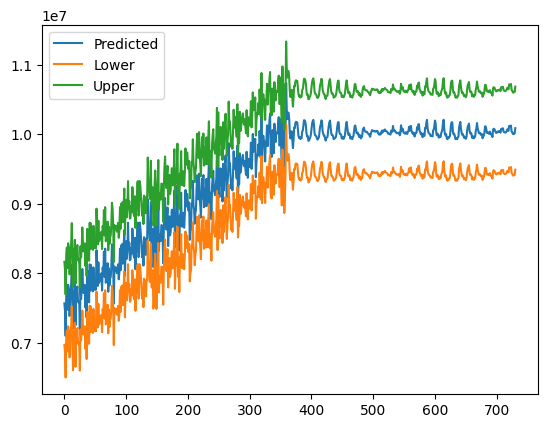

In [13]:
pyplot.plot(values, label='Predicted')
pyplot.plot(lower_bound, label='Lower')
pyplot.plot(upper_bound, label='Upper')
pyplot.legend()
pyplot.show()


# Exploring monthly Data.
I tried to sum the count for each month and try to predict. 

In [14]:
import pandas as pd
df = read_csv('data_daily.csv')
df['Date'] = pd.to_datetime(df['# Date'])

# Set the Date column as the DataFrame's index
df.set_index('Date', inplace=True)

# Resample the daily data to monthly and sum the 'receipt_count' for each month
monthly_data = df['Receipt_Count'].resample('M').sum()

# Create a new DataFrame with the monthly totals



In [15]:
import numpy as np
import pickle
from pandas import read_csv
values = monthly_data.values
values=values.reshape(-1,1)
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
modelMonth = MyRandomForestRegressor(n_estimators=1000)
modelMonth.fit(trainX, trainy)
pickle.dump(model, open('modelMonth.pkl','wb'))


In [16]:
# construct an input for a new prediction
for i in range(12):
    row = values[-6:].flatten()
    # make a one-step prediction
    yhat = modelMonth.predict(asarray([row]))
    print('Input: %s, Predicted: %.3f' % (row, yhat[0]))
    values=np.append(values,[yhat[0]]).reshape(-1,1)


Input: [274776003 283943231 281146154 295965185 296085162 309948684], Predicted: 304060457.317
Input: [2.83943231e+08 2.81146154e+08 2.95965185e+08 2.96085162e+08
 3.09948684e+08 3.04060457e+08], Predicted: 304060457.317
Input: [2.81146154e+08 2.95965185e+08 2.96085162e+08 3.09948684e+08
 3.04060457e+08 3.04060457e+08], Predicted: 304060457.317
Input: [2.95965185e+08 2.96085162e+08 3.09948684e+08 3.04060457e+08
 3.04060457e+08 3.04060457e+08], Predicted: 304060457.317
Input: [2.96085162e+08 3.09948684e+08 3.04060457e+08 3.04060457e+08
 3.04060457e+08 3.04060457e+08], Predicted: 304060457.317
Input: [3.09948684e+08 3.04060457e+08 3.04060457e+08 3.04060457e+08
 3.04060457e+08 3.04060457e+08], Predicted: 304060457.317
Input: [3.04060457e+08 3.04060457e+08 3.04060457e+08 3.04060457e+08
 3.04060457e+08 3.04060457e+08], Predicted: 304060457.317
Input: [3.04060457e+08 3.04060457e+08 3.04060457e+08 3.04060457e+08
 3.04060457e+08 3.04060457e+08], Predicted: 304060457.317
Input: [3.04060457e+08 

# Prediction and Inference
The prediction is parallel to x axis after the 12 months. This could be due to less data to train

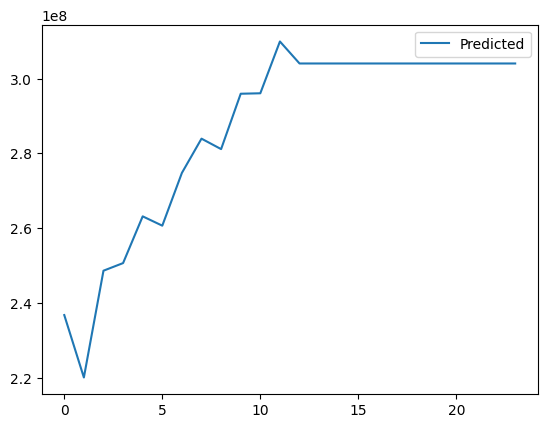

In [17]:
pyplot.plot(values, label='Predicted')
pyplot.legend()
pyplot.show()

# Exponential Smoothening
This was another approach I took to try capturing both volatility and linearity.

In [19]:
from statsmodels.tsa.api import ExponentialSmoothing

forecast_period = 365
series = read_csv('data_daily.csv', header=0, index_col=0)
train_data = series.values

# Fit data 
model = ExponentialSmoothing(
    train_data,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

# Forecast next 5 periods
forecast = model.forecast(forecast_period)

/Users/anudeep/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


# Prediction and Inference
Her we can observe the prediction was offset and could not capture enough volatility.

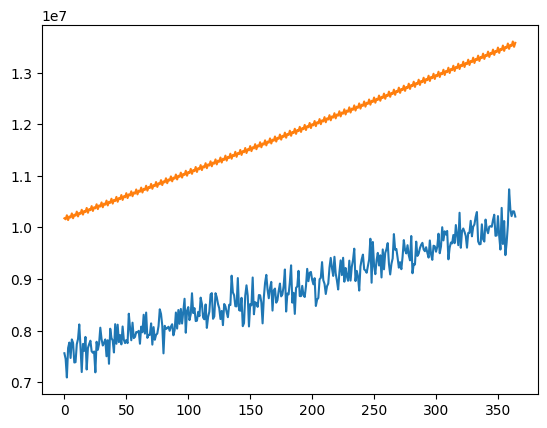

In [21]:
pyplot.plot(series.values, label='Expected')
pyplot.plot(forecast,label='Predicted')

# LSTM Approach

In [22]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]



/var/folders/kr/tmv0s2jx5nzbfv914ndj8tq00000gn/T/ipykernel_96789/4134949855.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


# Training
Training the network on the train data of 0:354 and test of 354:365 index. The hyperparamters:
batch_size=1
epochs=2000
neurons=4
PS: Tried 3000 epochs and it overfit


In [28]:
# load dataset
series = read_csv('data_daily.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# transform data to be stationary
raw_values = series.values

diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 2000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 


/var/folders/kr/tmv0s2jx5nzbfv914ndj8tq00000gn/T/ipykernel_96789/3507875133.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('data_daily.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


352/352 [==============================] - 0s 504us/step


array([[ 1.46348476e-01],
       [ 8.42006505e-02],
       [ 4.64723080e-01],
       [-5.36209047e-02],
       [-1.82055831e-02],
       [ 2.24224865e-01],
       [-1.76807523e-01],
       [ 4.80963886e-02],
       [ 4.35247421e-01],
       [ 4.06829119e-01],
       [-9.26375389e-03],
       [ 1.17441416e-02],
       [-3.01164567e-01],
       [ 1.26399636e-01],
       [ 5.16162634e-01],
       [-1.63492650e-01],
       [ 1.39004439e-01],
       [-1.47593260e-01],
       [ 4.84221607e-01],
       [-9.54305530e-02],
       [ 9.02634859e-03],
       [-1.02560341e-01],
       [ 7.58191049e-02],
       [ 1.83219194e-01],
       [ 2.09519386e-01],
       [ 5.39355099e-01],
       [-1.64909840e-01],
       [ 1.36877209e-01],
       [ 5.97410202e-02],
       [-2.77413547e-01],
       [-4.58738208e-02],
       [ 2.85418630e-02],
       [ 1.26782596e-01],
       [ 1.33575395e-01],
       [ 4.09151316e-01],
       [ 2.47162580e-03],
       [ 4.07740206e-01],
       [-3.51549745e-01],
       [ 2.8

# Testing

1/1 [==============================] - 0s 12ms/step
Day=1, Predicted=9820796.729387, Expected=10379305.000000
1/1 [==============================] - 0s 9ms/step
Day=2, Predicted=9969202.397737, Expected=9680446.000000
1/1 [==============================] - 0s 10ms/step
Day=3, Predicted=9905292.007871, Expected=10124238.000000
1/1 [==============================] - 0s 10ms/step
Day=4, Predicted=9858300.057973, Expected=9464659.000000
1/1 [==============================] - 0s 9ms/step
Day=5, Predicted=9746142.728592, Expected=9703857.000000
1/1 [==============================] - 0s 9ms/step
Day=6, Predicted=9646149.017829, Expected=10045897.000000
1/1 [==============================] - 0s 10ms/step
Day=7, Predicted=9779709.054248, Expected=10738865.000000
1/1 [==============================] - 0s 9ms/step
Day=8, Predicted=10028117.302366, Expected=10350408.000000
1/1 [==============================] - 0s 9ms/step
Day=9, Predicted=10172640.433273, Expected=10219445.000000
1/1 [===========

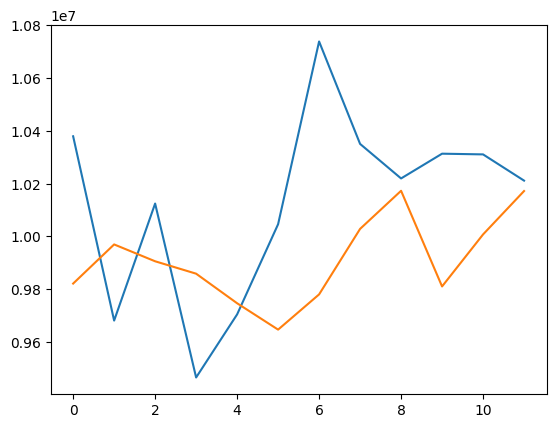

In [29]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:],label='Expected')
pyplot.plot(predictions,label='Predicted')
pyplot.show()

# Saving the Model

In [30]:
lstm_model.save('my_lstm_model.h5')

/Users/anudeep/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Predict future 100 days

In [35]:
series = read_csv('data_daily.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
mytrain, mytest = supervised_values[:], supervised_values[:]
 
# transform the scale of the data
myscaler, mytrain_scaled, mytest_scaled = scale(mytrain, mytest)
predictions = list()
for i in range(365):
    row = mytrain_scaled[i,-1].flatten()
    # make a one-step prediction
    yhat = forecast_lstm(lstm_model, 1, row)
    nxtiter=np.append(row,yhat)
    mytrain_scaled=np.concatenate((mytrain_scaled,nxtiter.reshape(1,-1)),axis=0)
    yhat = invert_scale(myscaler, row, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat)
    print('Day=%d, Predicted=%f' % (365+i+1, yhat))
    predictions.append(yhat)
    raw_values=np.append(raw_values,int(yhat))



    
    


1/1 [==============================] - 0s 12ms/step
Day=366, Predicted=10415022.893087
1/1 [==============================] - 0s 10ms/step
Day=367, Predicted=10892516.246368
1/1 [==============================] - 0s 10ms/step
Day=368, Predicted=10821511.063167
1/1 [==============================] - 0s 9ms/step
Day=369, Predicted=10853448.083379
1/1 [==============================] - 0s 9ms/step


/var/folders/kr/tmv0s2jx5nzbfv914ndj8tq00000gn/T/ipykernel_96789/1299974854.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('data_daily.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Day=370, Predicted=11114629.339287
1/1 [==============================] - 0s 10ms/step
Day=371, Predicted=11017929.860030
1/1 [==============================] - 0s 9ms/step
Day=372, Predicted=11097805.961916
1/1 [==============================] - 0s 10ms/step
Day=373, Predicted=11489327.352512
1/1 [==============================] - 0s 29ms/step
Day=374, Predicted=11806730.249803
1/1 [==============================] - 0s 9ms/step
Day=375, Predicted=11789360.911508
1/1 [==============================] - 0s 9ms/step
Day=376, Predicted=11793910.521100
1/1 [==============================] - 0s 10ms/step
Day=377, Predicted=11551961.615896
1/1 [==============================] - 0s 9ms/step
Day=378, Predicted=11670313.554253
1/1 [==============================] - 0s 9ms/step
Day=379, Predicted=12099049.460147
1/1 [==============================] - 0s 10ms/step
Day=380, Predicted=11965508.328423
1/1 [==============================] - 0s 9ms/step
Day=381, Predicted=12075652.328211
1/1 [=========

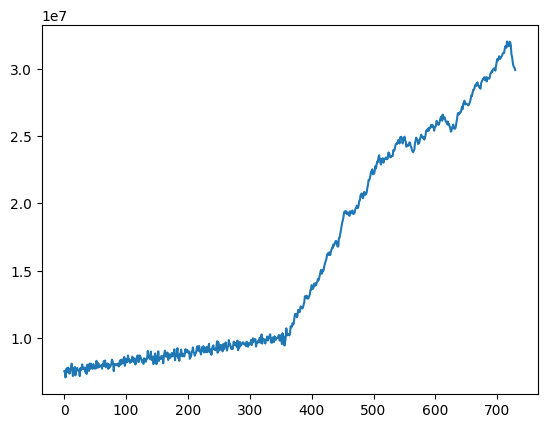

In [36]:
pyplot.plot(raw_values)
pyplot.show()